<a href="https://colab.research.google.com/github/ramiz11/ChatBot/blob/main/Final_Project_Chatbot_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### setup

In [ ]:
!pip install sentence-transformers
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import pickle as pkl
import os.path
from urllib.request import urlopen, Request
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
!pip install xgboost==1.4.1
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
!apt install -qq enchant
!pip install pyenchant
import enchant
eng_dict = enchant.Dict("en_US")
!pip install shapely
from shapely.geometry import Point, Polygon
!pip install geopandas
import geopandas as gpd
import fiona
!pip install contextily
import contextily as ctx
from os.path import join
from IPython.display import HTML

In [ ]:
# load previous chat results (if exist)
def load_file(filename, df=None):
    global url

    if os.path.isfile(filename):
        df = pd.read_csv(filename)
    else:
        try:
            f = urlopen(Request(f'{url}{filename}'))
            df = pd.read_csv(f'{url}{filename}', encoding='utf-8-sig')
            if 'Unnamed: 0' in df.columns:  #### rami
                df.drop('Unnamed: 0',axis=1,inplace=True)
        except:
            pass
    return df.fillna('')

### NLU Component - understanding the user's intent

#### Initalize and load data

In [ ]:
fresh = True # load existing data or fresh start
url="http://raw.githubusercontent.com/amirashiri/chatbot/main/"
map_url = 'http://raw.githubusercontent.com/amirashiri/YelpEDA/main'
SEPARATOR = 100
IMPORTANCE = 200
CERTAINTY = 2/3
active_intent_code = 2
guided = False
debug = 0

if fresh:
    intents = load_file('intents.csv')
    degree = load_file('degree.csv')
else:
    intents = load_file('intents_.csv', intents)
    degree = load_file('degree_.csv', values)
intent_codes = load_file('intent_codes.csv')
ranges = load_file('ranges.csv')

bert = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [ ]:
# load and adjust restaurants data
rest = pd.read_csv(f'{url}restaurants.csv')[['name', 'address', 'latitude', 'longitude', 'price', 'stars', 'business_type', 'kitchen_type', 'veggy', 'GoodForKids', 'WiFi', 'OutdoorSeating', 'romantic', 'parking',
       'Sunday_open', 'Sunday_close', 'Monday_open', 'Monday_close', 'Tuesday_open', 'Tuesday_close', 'Wednesday_open', 'Wednesday_close', 'Thursday_open', 'Thursday_close', 'Friday_open', 'Friday_close', 'Saturday_open', 'Saturday_close']]
for day in ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']:
    for open_close in ['open', 'close']:
        col = day + '_' + open_close
        rest[col] = pd.to_datetime(rest[col], format='%H:%M:%S') - pd.to_datetime(rest[col], format='%H:%M:%S').dt.normalize()
rest.loc[rest.business_type == 'other', 'business_type'] = 'restaurant'
rest.loc[rest.business_type == 'Steakhouses', 'business_type'] = 'restaurant'
rest.business_type = rest.business_type.str.lower()
rest = rest.loc[rest.business_type.isin(['restaurant', 'bar', 'pizza', 'cafe']), :]
rest = rest.loc[rest.price != 'None', :]
rest.price = pd.to_numeric(rest.price)
rest.rename(columns={'stars': 'ranking', 'GoodForKids': 'kids', 'WiFi': 'wifi', 'OutdoorSeating': 'outdoor'}, inplace=True)
rest.head(3)

,name,address,latitude,longitude,price,ranking,business_type,kitchen_type,veggy,kids,wifi,outdoor,romantic,parking,Sunday_open,Sunday_close,Monday_open,Monday_close,Tuesday_open,Tuesday_close,Wednesday_open,Wednesday_close,Thursday_open,Thursday_close,Friday_open,Friday_close,Saturday_open,Saturday_close
0,Pho Lee's Vietnamese Restaurant,"1541 E 38th St, Ste 101",41.512155,-81.663332,NaN,4.5,restaurant,Vietnamese,False,False,False,False,False,False,0 days 11:00:00,0 days 20:00:00,0 days 11:00:00,0 days 20:00:00,NaT,NaT,0 days 11:00:00,0 days 20:00:00,0 days 11:00:00,0 days 20:00:00,0 days 11:00:00,0 days 20:00:00,0 days 11:00:00,0 days 20:00:00
2,Hingetown,NaN,41.489343,-81.711029,4.0,3.0,cafe,other,False,True,False,True,False,False,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,Dominic's Santos,21467 Lorain Rd,41.443652,-81.858176,2.0,3.5,pizza,American,False,True,False,True,False,True,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [ ]:
# build info summary for restaurant details
rest_ = rest.copy()
rest_.price = np.select([rest_.price == 1, rest_.price == 2, rest_.price.between(3, 4)], ['low prices', 'medium prices', 'high prices'], '')
rest_.ranking = np.select([rest_.ranking <= 1.5, rest_.ranking.between(2, 3.5), rest_.ranking.between(4, 5)], ['low rating', 'medium rating', 'high rating'], 'no rating info')
rest_.kitchen_type = np.where(rest_.kitchen_type == 'other', '', rest_.kitchen_type + ' kitchen')
rest_.outdoor = np.where(rest_.outdoor == True, 'has outdoor seating', '')
rest_.veggy = np.where(rest_.veggy == True, 'vegetarian', '')
rest_.kids = np.where(rest_.kids == True, 'kids friendly', '')
rest_.wifi = np.where(rest_.wifi == True, 'has WiFi', '')
rest_.romantic = np.where(rest_.romantic == True, 'romantic', '')
rest_.parking = np.where(rest_.parking == True, 'has parking', '')

rest['details'] = ''
for col in ['kitchen_type', 'business_type', 'ranking', 'price', 'veggy', 'romantic', 'kids', 'outdoor', 'wifi', 'parking']:
    rest.details = np.where(rest_[col].str.len() == 0, rest.details, rest.details + np.where(rest.details.str.len() == 0, '', ', ') + rest_[col])
rest[['name', 'address', 'details']].head(3)

,name,address,details
0,Pho Lee's Vietnamese Restaurant,"1541 E 38th St, Ste 101","Vietnamese kitchen, restaurant, high rating"
2,Hingetown,NaN,"cafe, medium rating, high prices, kids friendl..."
3,Dominic's Santos,21467 Lorain Rd,"American kitchen, pizza, medium rating, medium..."


In [ ]:
# Build Cleveland map
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip (rest.longitude, rest.latitude)]
geo = gpd.GeoDataFrame(rest, crs=crs, geometry=geometry)
geo = geo.to_crs(epsg=3857)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Train classifiers

In [ ]:
# train boolean classifiers for is_intent (yes/no) and intent (e.g. 'price'), and same for degree (e.g. 'low')
values_cols = ['kitchen_type', 'business_type', 'food']
values_intent_codes = intent_codes.loc[intent_codes.intent_name.isin(values_cols), 'intent_code'].unique()

def build_clf(df):
    df = df.sample(len(df))
    df.reset_index(drop=True, inplace=True)
    X = pd.DataFrame(bert.encode(df.name))
    y = df.code.astype('int')
    clf = xgb.XGBClassifier(silent=True, verbosity=0)
    clf.fit(X, y)
    return clf

included_train = intents.loc[((intents.include == 1) & ~(intents.code.isin(values_intent_codes))) | (intents.code == 0)]
is_intent_clf = build_clf(included_train.assign(code=np.where(included_train.code > 0, 1, 0)))
intent_clf = build_clf(included_train.loc[included_train.code > 0])

excluded_train = intents.loc[((intents.include == 1) | (intents.code <= 0)) & ~(intents.code.isin(values_intent_codes))]
is_excluded_clf = build_clf(excluded_train.assign(code=np.where(excluded_train.code < 0, 1, 0)))
excluded_clf = build_clf(excluded_train.loc[excluded_train.code < 0])

is_degree_clf = build_clf(degree.assign(code=np.where(degree.code == 0, 0, 1)))
degree_clf = build_clf(degree.loc[degree.code != 0])

In [ ]:
# train boolean classifiers multiple values columns: kitchen type, business type, food
def intent_values_clf(model_name):
    intent_code = intent_codes.loc[intent_codes.intent_name == model_name, 'intent_code'].iloc[0]
    df = intents.loc[intents.code == intent_code, ['name', 'value_code']].copy()
    df.rename(columns={'value_code': 'code'}, inplace=True)
    values_clf = build_clf(df)
    is_values_clf = build_clf(intents.assign(code=np.where(intents.code == intent_code, 1, 0)))
    return is_values_clf, values_clf

is_values_clf = {}
values_clf = {}
for col in values_cols:
    values_clfs = intent_values_clf(col)
    is_values_clf[col]= values_clfs[0]
    values_clf[col]= values_clfs[1]

### parse and tag sentence words

In [ ]:
found_class = 0
lem = WordNetLemmatizer() 

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# clean punctuations and stopwords from a sentence
def clean(sentence):
    sentence = re.sub(r"don't", "do not", sentence)
    sentence = re.sub(r"doesn't", "does not", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "can not", sentence)
    sentence = re.sub(r"shouldn't", "should not", sentence)
    sentence = re.sub(r"without", "no", sentence)
    sentence = re.sub(r"I am", "", sentence)
    sentence = re.sub(r"i am", "", sentence)

    sentence = re.sub(r"unimportant", "not important", sentence)
    sentence = re.sub(r"insignificant", "not important", sentence)
    sentence = re.sub(r"irrelevant", "not important", sentence)
    sentence = re.sub(r"unnecessary", "not important", sentence)
    sentence = re.sub(r"meaningless", "not important", sentence)
    sentence = re.sub(r"bonus", "not important", sentence)
    sentence = re.sub(r"any", "not important", sentence)
    sentence = re.sub(r"all kinds", "not important", sentence)
    sentence = re.sub(r"all sorts", "not important", sentence)
    sentence = re.sub(r"whatever", "not important", sentence)
    sentence = re.sub(r"today", datetime.now().strftime('%A'), sentence)
    sentence = re.sub(r"tomorrow", (datetime.now() + timedelta(days=1)).strftime('%A'), sentence)

    sentence = re.sub(r"\bone\b", "1", sentence)
    sentence = re.sub(r"\btwo\b", "2", sentence)
    sentence = re.sub(r"\bthree\b", "3", sentence)
    sentence = re.sub(r"\bfour\b", "4", sentence)
    sentence = re.sub(r"\bfive\b", "5", sentence)
    sentence = re.sub(r"\bsix\b", "6", sentence)
    sentence = re.sub(r"\bseven\b", "7", sentence)
    sentence = re.sub(r"\beight\b", "8", sentence)
    sentence = re.sub(r"\bnine\b", "9", sentence)
    sentence = re.sub(r"\bten\b", "10", sentence)
    sentence = re.sub(r"twenty", "20", sentence)
    sentence = re.sub(r"thirty", "30", sentence)
    sentence = re.sub(r"fourty", "40", sentence)
    sentence = re.sub(r"fifty", "50", sentence)
    sentence = re.sub(r"couple", "2", sentence)
    sentence = re.sub(r'([0-9]+?[ ]?)([AapP][.]?[mM][.]?)', r'\1 \2' , sentence)

    sentence = sentence.replace(',', ' , ')
    sentence = [char for char in sentence if char not in string.punctuation or char in [',', ':']]
    sentence = ''.join(sentence)

    sentence = ' '.join([lem.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)])

    sentence = ' '.join([word for word in sentence.split()
        if (word.lower() not in stopwords.words('english') and
            (eng_dict.check(word.lower()) or eng_dict.check(word.capitalize()))) or
            (word in degree.name.values or word in intents.name.values) or
            any(char.isdigit() for char in word)])
          
    return sentence

def add_row(df, values):
    temp_df = pd.DataFrame(columns=df.columns)
    temp_df.loc[0] = values
    return df.append(temp_df).reset_index(drop=True)

def get_word(word, is_clf, clf, is_intent=True, is_values=False):
    global word_codes, found_class

    if found_class and is_intent:
        return
    word_ = bert.encode([word])
    if is_clf.predict(word_)[0]:
        proba = clf.predict_proba(word_)
        if proba.max() > CERTAINTY or is_values:
            found_class = clf.classes_[np.argmax(proba)]
            if is_intent and found_class > 100:
                found_class = found_class // 100
            clf_type = 'intent' if is_intent else 'degree'
            word_codes = add_row(word_codes, [word, clf_type, found_class])

# return intent info for a given sentence, intent_value may be given, or predicted
def get_words(sentence):
    global word_codes, found_class

    word_codes = pd.DataFrame(columns=['word', 'word_type', 'word_code'])
    for word in clean(sentence).split():
        if word in ['no', 'not']:
            word_codes = add_row(word_codes, [word, 'negative', 0])
            continue
        if any(char.isdigit() for char in word):
            word_codes = add_row(word_codes, [word, 'decimal', 0])
            continue
        get_word(word, is_degree_clf, degree_clf, is_intent=False)
        found_class = 0        
        for col in values_cols:
            get_word(word, is_values_clf[col], values_clf[col], is_values=True)
        get_word(word, is_excluded_clf, excluded_clf)
        get_word(word, is_intent_clf, intent_clf)
    return word_codes.reset_index(drop=True)

### Create slots with meaningful intents


In [ ]:
# return the start/end values from the ranges dataframe, per given intent and value
def range_values(intent_code, range_value_code):
    val = ranges.loc[(ranges.intent_code == intent_code) & (ranges.value_code == range_value_code), ['start_val', 'end_val']]
    return val.iloc[0].tolist() if len(val) > 0 else 0

def reset_indicators():
    global intent_name, intent_type, degree_code, decimal, negative, negative_degree, negative_importance
    intent_name, intent_type, degree_code, decimal = '', '', 0, 0
    negative, negative_importance, negative_degree = False, False, False

def add_slot(slots, intent_name, intent_value, excluded=False):
    global negative_degree, negative_importance
    slots = add_row(slots, [intent_name, intent_value, negative_degree, negative_importance, excluded])
    reset_indicators()
    return slots

def add_slots(word_codes):
    global intent_name, intent_type, degree_code, decimal, negative, negative_importance, negative_degree

    active_intent_name = intent_codes.loc[active_intent_code, 'intent_name']
    active_intent_type = intent_codes.loc[active_intent_code, 'intent_type']
    word_codes['dup'] = np.where(word_codes.word_type == 'intent', -1, word_codes.index) 
    word_codes = word_codes.drop_duplicates(subset=['dup', 'word_code'], keep='last').drop(columns='dup')
    word_codes = add_row(word_codes, ['', 'degree', SEPARATOR])
    word_codes = word_codes.merge(intent_codes, left_on='word_code', right_on='intent_code', how='left').fillna('')
    slots = pd.DataFrame(columns=['intent_name', 'intent_value', 'negative_degree', 'negative_importance', 'excluded'])
    reset_indicators()

    for idx, row in word_codes.iterrows():
        if debug:
            print(row.word, end=': ')

        # negation
        if row.word_type == 'negative':
            negative = not negative
        else:
            if negative:
                if row.word_code == IMPORTANCE:
                    negative_importance = True
                    negative = False
                    if debug:
                        print('negative importance')
                else:
                    negative_degree = True
                    negative = False
                    if debug:
                        print('negative degree')

        # add a slot if a new intent/degree or separator/number is identified
        # if (row.word_type == 'intent' and (intent_name != '' or (guided and len(slots) == 0))) or\    
        if row.word_type == 'intent' or\
           (row.word_type == 'degree' and row.word_code < 100 and degree_code != 0) or\
            row.word_code == SEPARATOR or row.word_type == 'decimal':

            if debug:
                if row.word_code == SEPARATOR:
                    print('sep')
                else:
                    print('new intent')

            # in guided mode, for the 1st slot, if there is a range-degree or importance without intent, add the active intent
            if intent_name == '' and row.word_type != 'intent':
                if guided and len(slots) == 0 and (negative_importance or ((degree_code != 0) and active_intent_type == 'range')):
                    intent_name = active_intent_name
                    intent_type = active_intent_type
                    if debug:
                        print('using active intent')
                else:
                    reset_indicators()
                    if debug:
                        print('no intent - skipping')

            # range intent
            if intent_type == 'range':
                if degree_code != 0:
                    intent_code = intent_codes.index[intent_codes.intent_name == intent_name][0]
                    slots = add_slot(slots, intent_name, range_values(intent_code, degree_code))
                    if debug:
                        print('add degree and range')
                else:
                    slots = add_slot(slots, intent_name, '')
                    reset_indicators()
                    if debug:
                        print('add range without degree')

            # decimal intents: people, day, time
            if intent_type == 'decimal':
                if intent_name == 'people':
                    people = decimal if isinstance(decimal, int) else (int(decimal) if decimal.isnumeric() else 0) 
                    slots = add_slot(slots, intent_name, people if people > 0 else '') 
                    if debug:
                        print('added people')
                elif intent_name == 'time':
                    slots = add_slot(slots, intent_name, extract_time(decimal + word))
                    if debug:
                        print('added time')
                elif intent_name == 'day':
                    slots = add_slot(slots, intent_name, extract_day(word))

            # yes/no intent
            if intent_type == 'bool':
                slots = add_slot(slots, intent_name, True)
                if debug:
                    print('added bool')

            # values intent (kitchen or business type)
            elif intent_type == 'values':
                proba = values_clf[intent_name].predict_proba(bert.encode([word]))
                if proba.max() >  CERTAINTY:
                    value_code =  values_clf[intent_name].classes_[np.argmax(proba)]
                    intent_value = intents.loc[intents.value_code == value_code, 'value_name'].iloc[0]
                else:
                    intent_value = ''
                slots = add_slot(slots, intent_name, intent_value)
                if debug:
                    print('added values')

            # intents without data
            elif intent_type == 'excluded':
                slots = add_slot(slots, intent_name, word, excluded=True)
                if debug:
                    print('added excluded intent')

        # prepare the next intent/degree values for the next iteration
        if row.word_type == 'intent':
            word = row.word
            intent_name = row.intent_name
            intent_type = row.intent_type
            if debug:
                print('intent update')
        if row.word_type == 'degree' and row.word_code < SEPARATOR:            
            degree_code = row.word_code
            if debug:
                print('degree update')
        if row.word_type == 'decimal':
            decimal = row.word
            if debug:
                print('decimal update')

    return slots

### Classifiers Evaluation

In [ ]:
# Intents
eval_sentences = load_file('eval_sentences.csv')
words = []
for _idx, row in eval_sentences.iterrows():
    words += row.text.split()
eval_intents_base = pd.DataFrame({'text': words}).drop_duplicates()
eval_intents_base.text = eval_intents_base.text.str.replace(',', '')
eval_intents_base.to_csv('eval_intents_base.csv')

In [ ]:
eval_intents = load_file('eval_intents.csv')
eval_results = pd.DataFrame()
for _, row in eval_intents.iterrows():
    if row.text == '':
        continue
    results = get_words(row.text).rename(columns={'word': 'text', 'word_type': 'type', 'word_code': 'code'})
    if row['type'] != '':
        results = results.loc[results['type'] == row['type']]
    eval_results = eval_results.append(results)
eval_results = eval_results.merge(intent_codes.assign(type='intent').\
    rename(columns={'intent_code': 'code', 'intent_name': 'value'})[['type', 'code', 'value']],
    on=['type', 'code'], how='left')

eval_results.loc[eval_results['type'] == 'degree', 'value'] = eval_results.code.map({1: 'low', 2: 'medium', 3: 'high', 5: 'context', 100: 'separator', 200: 'care'})
eval_results.drop(columns='code', inplace=True)
eval_results.drop_duplicates(inplace=True)

eval_intents.text = eval_intents.text.apply(clean)
eval_intents = eval_intents.loc[eval_intents.text.apply(len) > 0].drop_duplicates()
eval_results = eval_intents.merge(eval_results, on='text', how='outer')
eval_results.fillna('', inplace=True)
eval_results['same'] = (eval_results.value_x == eval_results.value_y)*1
eval_results = eval_results.sort_values(by='same', ascending=False).groupby(['text', 'type_x']).head(1)
eval_results.drop(columns='same', inplace=True)
eval_results['intent'] = np.where(eval_results.type_x == '', False, True)
eval_results['predicted_intent'] = np.where(
    (eval_results.type_x == eval_results.type_y) & (eval_results.value_x == eval_results.value_y), eval_results.intent, ~eval_results.intent)
eval_results.head(3)

,text,type_x,value_x,type_y,value_y,intent,predicted_intent
0,good,degree,context,degree,context,True,True
1,restaurant,intent,business_type,intent,business_type,True,True
31,vegetarian,intent,veggy,intent,veggy,True,True


              precision    recall  f1-score   support

       False       0.83      0.95      0.88        20
        True       0.97      0.89      0.93        35

    accuracy                           0.91        55
   macro avg       0.90      0.92      0.90        55
weighted avg       0.92      0.91      0.91        55




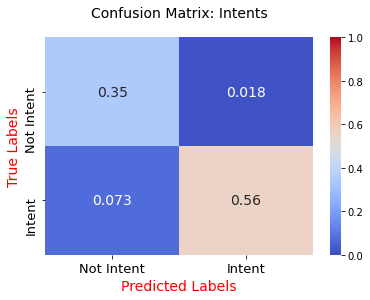

In [ ]:
print(classification_report(eval_results.intent, eval_results.predicted_intent))
print()
cm = confusion_matrix(eval_results.intent, eval_results.predicted_intent, normalize='all')
ax = sns.heatmap(cm, annot=True, fmt='.2g', cmap='coolwarm', annot_kws={"size":14}, vmin=0, vmax=1);
ax.set_xlabel('Predicted Labels', fontsize=14, color='red');
ax.set_ylabel('True Labels', fontsize=14, color='red'); 
ax.set_title('Confusion Matrix: Intents', fontsize=14, pad=20); 
ax.xaxis.set_ticklabels(['Not Intent', 'Intent'], fontsize=13);
ax.yaxis.set_ticklabels(['Not Intent', 'Intent'], fontsize=13);

In [ ]:
# Sentences
eval_slots = load_file('eval_slots.csv')
eval_slots.intent_value = np.where(eval_slots.intent_value == 'TRUE', True, eval_slots.intent_value)

eval_results = pd.DataFrame()
for _, row in eval_sentences.iterrows():
    results = add_slots(get_words(row.text))[['intent_name', 'intent_value']]
    results.insert(0, 'sentence_code', row.sentence_code)
    eval_results = eval_results.append(results)
eval_results.reset_index(drop=True, inplace=True)    
eval_results = eval_results.merge(intent_codes[['intent_name', 'intent_code']], on='intent_name', how='left')

for idx, row in eval_results.iterrows():
    if isinstance(row.intent_value, list):
        eval_results.loc[idx, 'intent_value'] = f'{row.intent_value[0] :.1f}-{row.intent_value[1] :.1f}'
ranges['intent_value'] = ranges.apply(lambda row: f'{row.start_val :.1f}-{row.end_val :.1f}', axis=1)
eval_results = eval_results.merge(
    ranges.loc[ranges.value_code != 5, ['intent_code', 'intent_value', 'value_code']], on=['intent_code', 'intent_value'], how='left')
eval_results.intent_value = np.where(eval_results.value_code.notnull(), eval_results.value_code.map({1: 'low', 2: 'medium', 3: 'high'}), eval_results.intent_value)
eval_results.drop(columns=['intent_code', 'value_code'], inplace=True)

eval_slots.rename(columns={'intent_name': 'intent_name_x'}, inplace=True)
eval_results.rename(columns={'intent_name': 'intent_name_y'}, inplace=True)
eval_results = eval_slots.merge(eval_results, left_on=['sentence_code', 'intent_name_x'], right_on=['sentence_code', 'intent_name_y'], how='outer')
eval_results.fillna('', inplace=True)
eval_results['predicted_intent'] = np.where(
    ((eval_results.intent_name_x == eval_results.intent_name_y) & (eval_results.intent_value_x == eval_results.intent_value_y)) |
    ((eval_results.intent_name_x == '') & (eval_results.intent_name_y != '')), True, False)
eval_results['intent'] = np.where(eval_results.intent_name_x == '', False, True)

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         4
        True       0.81      0.71      0.76        24

    accuracy                           0.61        28
   macro avg       0.40      0.35      0.38        28
weighted avg       0.69      0.61      0.65        28




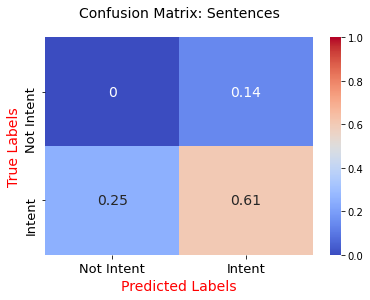

In [ ]:
print(classification_report(eval_results.intent, eval_results.predicted_intent))
print()
cm = confusion_matrix(eval_results.intent, eval_results.predicted_intent, normalize='all')
ax = sns.heatmap(cm, annot=True, fmt='.2g', cmap='coolwarm', annot_kws={"size":14}, vmin=0, vmax=1);
ax.set_xlabel('Predicted Labels', fontsize=14, color='red');
ax.set_ylabel('True Labels', fontsize=14, color='red'); 
ax.set_title('Confusion Matrix: Sentences', fontsize=14, pad=20); 
ax.xaxis.set_ticklabels(['Not Intent', 'Intent'], fontsize=13);
ax.yaxis.set_ticklabels(['Not Intent', 'Intent'], fontsize=13);

### Run the slots and show restaurants


In [ ]:
# filter restaurants according to slots criteria and sort in decending ranking order

def is_open(time, row):
    for day in ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']:
        if pd.to_timedelta(time) >= row[day + '_open'] and pd.to_timedelta(time) <= row[day + '_close']:
            return True
    return False

def run_slots(data, slots):
    df = data.copy()
    for idx, row in slots.iterrows():
        if row.negative_importance:
            continue
        if row.excluded:
            continue
        if row.intent_name == 'people':
            continue
        if isinstance(row.intent_value, list):
            if row.negative_degree:
                df = df.loc[~df[row.intent_name].between(row.intent_value[0], row.intent_value[1])]
            else:
                df = df.loc[df[row.intent_name].between(row.intent_value[0], row.intent_value[1])]
        elif row.intent_name == 'day':
            df = df.loc[df[row.intent_value.capitalize() + '_open'].notnull()]
        elif row.intent_name == 'time':
            if 'day' in slots.intent_name.values:
                day = slots.loc[slots.intent_name == 'day', 'intent_value'].iloc[0]
                df = df.loc[(pd.to_timedelta(row.intent_value) >= df[day.capitalize() + '_open']) &
                            (pd.to_timedelta(row.intent_value) <= df[day.capitalize() + '_close'])]
            else:
                df = df.loc[df.apply(lambda curr_row: is_open(row.intent_value, curr_row), axis=1)]
        else:
            if row.negative_degree:
                df = df.loc[df[row.intent_name] != row.intent_value]
            else:
                df = df.loc[df[row.intent_name] == row.intent_value]
    
    if check_data_shape(df):
        return [df,True]
    else:
        return [data,False]


def check_data_shape(data):
    "check if there is atleast 1 restaurant responding to a certain user specification"
    return data.shape[0]>0

def display_data(data,ok=True):
    "function that checks if there is any data responding to a certain user specifiation, if there is, it displays a sample of the current-subsetted data"
    answers=["Here is what I found according to your most recent answer:",
             "Here's what I discovered in response to your most recent response:",
             "In response to your most recent comment, I discovered:"]
    if ok:
        print(random.sample(answers,1)[0])
        print((data.sort_values(by='ranking', ascending=False)[['name','address', 'details']]).head(5))
        map_results(data)
        
    else:
        print("unfortunately i couldn't find any restaurants meeting your previous requirements, please try again:)")

def map_results(results):
    city_map = fiona.open(join(map_url, 'City_of_Cleveland_Neighborhoods_2012_no_lake.shp'))
    ax = geo.plot(figsize=(10, 10), color='blue', marker='o', markersize=20, label='All Places')
    geo[rest.name.isin(results.name)].plot(ax=ax, figsize=(10, 10), color='red', marker='o', markersize=200, label='Matching Places')
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.HOT)
    plt.legend(prop={'size': 15})
    plt.show()
    #plt.savefig("test.png")
    city_map.close()

    

Yes-No Binary classification model (implemented for the sake of boolean intent prediction)

In [ ]:
# load data:
yes_no_data=pd.read_csv('https://raw.githubusercontent.com/ramiz11/ChatBot/main/yes_no_data')
yes_no_data.drop('Unnamed: 0',axis=1,inplace=True)
yes_no_labelencoder = LabelEncoder()
yes_no_data['label_encoded'] = yes_no_labelencoder.fit_transform(yes_no_data['label'])
sentences=list(yes_no_data.sentence_input)
embeddings = bert.encode(sentences)
encoded_yes_no_data=pd.concat([pd.DataFrame(embeddings),yes_no_data],axis=1)
encoded_yes_no_data.drop(['sentence_input','label'],axis=1,inplace=True)
encoded_yes_no_data=encoded_yes_no_data.sample(len(encoded_yes_no_data))
# binary yes no classifier :
X=encoded_yes_no_data.drop(['label_encoded'],axis=1)
y=encoded_yes_no_data.label_encoded
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
yes_no_clf = SVC(probability=True)
yes_no_clf.fit(X,y)
print(classification_report(y,yes_no_clf.predict(X)))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.96      1.00      0.98        25

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.98        45
weighted avg       0.98      0.98      0.98        45



### Dialog-Flow Component

Conversation flow functions

In [ ]:
def intent_directing(message:str="greeting"):
    "function that returns the messages aimed to initiate a conversation with the user and keep its flow"
    message=message.lower()
    to_return=None
    # preparing the different kinds of messages
    ### genereal messages:
    greetings=["Hello, i am Mike, the restaurant reservation bot, i'm here to assist you, let's begin finding you a restaurant of your choice",
                       "Hi, i'm Mike, the restaurant reservation bot, and I'm here to help you. Let's get started finding you a restaurant that meets your needs",
                       "Hi! i am Mike,the restaurant reservation bot, let's find you a restaurant that fullfils your requirements"
                       ]
    summary=["Here is a list of the top 5 relevant restaurants fitted to your satisfaction",
                   "Here is a list of the top 5 restaurants that meet your preferences",
                   "Here is a list of the top 5 restaurants that cater to your requirements"]
    
    freehand=["When choosing a restaurant, what do you seek out in it?",
              "What do you look for in a restaurant when selecting one?",
              "When picking a restaurant, what are your preferences?"]
    
    ### order-related messages:
    time=['At what hour would you like to reserve a spot at the restaurant?'
    ,'At what hour should i reserve a spot for you?',
    "Can you tell me what is your preferred hour for the reservation?"]

    day=['which day would like me to reserve a spot for you?',
         'Which day should i reserve a spot for you?',
         'Can you tell me what is your preferred day for the reservation?']

    number_of_people=['How many people will be attending the restaurant?',
                      'To how many people should i reserve a spot?',
                      'How many people are expected to dine at the restaurant?']   
      
    kitchen_type=["What is your favourite type of kitchen?",
                  "What sort of kitchen do you prefer?",
                  "What sort of kitchen are you looking for?"]
    business_type=["What is your prefered restaurant type?",
                   "What kind of restaurant are you looking for?"
    ,"What is your favourite type of restaurant?"]

    # boolean intents
    satisfaction=["Are you satisfied with the chosen restaurants?",
                       "Are you pleased with the outcome?",
                       "Are you happy with the picked restaurants?"]
    veggy=["Do you like vegetarian food?",
           "Do you enjoy vegetarian food?",   
           "Are you a vegetarian?"]
    good_for_kids=["Are you coming along with kids?",
                   "Are you bringing your children?"
    ,"Are you taking your kids with you?"]

    romantic=["Are you looking for a romantic place?",
              "Do you want to go somewhere romantic?",
              "Are you looking for a romantic restaurant?"]
    
    wifi=["Are you looking for a restaurant with a Wifi?",
          "Are you searching for a palce with a Wifi",
          "Are you seeking out a restaurant with Wifi"]

    outdoor=["Would you like outdoor dining?",
             "Do you want to dine outside?",
             "Do you enjoy eating outside?"]
    parking=["Do you prefer a place with parking?",
             "Do you prefer a restaurant that has parking?",
             "Do you want to dine at a restaurant that has parking?"]

    ### preferences-related messages:
    price=["From a scale of high to low, which price range do you prefer?",
           "Which price range do you like, on a scale of high to low?",
           "Which pricing range do you like on a scale of low to high?"]

    ranking=["Which ranking do you best prefer from a scale of low to high",
             "From a scale of high to low, which ranking do you most prefer?",
             "Which ranking range do your prefer from scale of low to high?"]
    
    
    # return relevant message:
    if 'greet' in message:
        to_return=random.sample(greetings,1)[0]
        to_return+="\n"+"enter the word 'help' if you would like to get guidance for what kind of requests you can seek from me"
    elif 'satis' in message:
        to_return=random.sample(satisfaction,1)[0] 
    elif 'veg' in message:
        to_return=random.sample(veggy,1)[0]
    elif 'kids' in message:
        to_return=random.sample(good_for_kids,1)[0]
    elif 'romantic' in message:
        to_return=random.sample(romantic,1)[0]
    elif 'wifi' in message:
        to_return=random.sample(wifi,1)[0]
    elif 'out' in message:
        to_return=random.sample(outdoor,1)[0]
    elif 'park' in message:
        to_return=random.sample(parking,1)[0]
    elif 'sum' in message:
        to_return=random.sample(summary,1)[0]
    elif 'free' in message:
        to_return=random.sample(freehand,1)[0]
    elif 'bus' in message:
        to_return=random.sample(business_type,1)[0]
    elif 'kit' in message:
        to_return=random.sample(kitchen_type,1)[0]
    elif 'time' in message:
        to_return=random.sample(time,1)[0]
    elif 'day' in message:
        to_return=random.sample(day,1)[0]
    elif 'num' in message:
        to_return=random.sample(number_of_people,1)[0]
    elif 'price' in message:
        to_return=random.sample(price,1)[0]    
    elif 'rank' in message:
        to_return=random.sample(ranking,1)[0]

    return to_return



def intent_response(intent_message:str='goodbye',message=None):
    "function that returns the messages which are given as a response to a specific intent"
    #### add responses for kitchen and business type  and parking
    intent_message=intent_message.lower()
    to_return=None   
    parking=["looking for places with parking..."]
    kids=["looking for places suitable to kids..."]
    romantic=["looking for ramantic places..."]
    kitchen=[f"looking for places with kitchen type: {message}"]
    business_type=[f"looking for places with business type: {message}"]
    veggy=["looking for places suitable to vegetarians... "]
    wifi=["looking for places with available Wifi..."]
    outdoor=["looking for places with outdoor seating availability..."]


    # the exact entered hour/day/number of people will be appended to the end of sentences of those intents (order-related)
    time=['Looking for restaurants available at ',
          'Searching for restaurants that are open at ',
          'Searching for open restaurants at ']
    day=['Looking for restaurants available on ',
         'Searching for restaurants that are open on ',
         'Searching for open restaurants on ']
    
    boolean_intents=["Ok,noted.","Got it","You got it"]
    people_begin=['Looking for places suitable to ','Searching for restuarants appropriate for ','Looking for locations suitable to ']
    people_end=[' people...',' individuals...']

    out_of_topic=['Oops, it seems as if you have entered an answer out of my scope.',
                "Unfortunately, it appears that you have entered an answer that is outside of my scope.",
                'Sorry, it looks like you have entered an answer that is not within the limits of my expertise.']

    not_same_intent_begin=["you answer was noted, and a search will be made accordingly; however you've answered on a different topic:  ",
                     "Your response was noticed, and a search will be conducted appropriately; however, you responded on a separate topic: ",
                     "Your comment was noted, and a search will be done accordingly; however, you responded on a different issue: "]
    not_same_intent_end=['Make sure your answer refers to the question',' Please ensure that your response pertains to the question','Please make sure that your response is relevant to the question']

    already_answered=["You've already answered on this topic, please refer to the question",
                      "You've previously responded on this subject, please answer in accordance to the newly asked question",
                      "You've previously answered on this subject,please respond in accordance with the new question."]
    
    no_value_provided_begin=["I understood you answered on: ","I understood you responded on: ","As I understand, you answered on: "]
    no_value_provided_end=[", However, you have not offered any specific details.",
                           ", You haven't supplied any particular information, however.",
                           "However, you haven't provided any specific details."]

    goodbye_satisfied=["Awesome!, enjoy your time, see you soon!",
                      "Great to hear!,had a blast assisting you, see you next time!",
                      "Wonderful!,enjoy you time, take care!",
                      "Great to hear!, hope you will enjoy your time, goodbye",
                      "Awesome!, it was nice assisting you, see you later!"]

    restart=["I understand, no need to be concerned, let's go over your order again and find you an ideal list of restaurants ",
                                   "I see, let's restart and find you a list of restaurants that satisfy your requirements",
                                   "No worries, we will go over your preferences again and find you an optimal list of restaurants!"]


    if 'price' in intent_message:   
        to_return="looking for " 
        if message==[3,4]:
            to_return+='high priced'
        elif message==[2,2]:
            to_return+='medium priced'
        elif message==[1,1]:
            to_return+="low priced"
        to_return+=' places'
 
    elif 'rank' in intent_message:
        to_return="looking for"
        if message==[4,5]:  
            to_return+=" high ranked"
        elif message==[2,3.5]:
            to_return+=" medium ranked"
        elif message==[1,1.5]:
            to_return+=" low ranked"
        to_return+=" places"

    elif 'time' in intent_message:
        begin=random.sample(time,1)[0]
        end=message
        to_return=begin+end

    elif 'day' in intent_message:
        begin=random.sample(day,1)[0]
        end=message
        to_return=begin+end
    elif 'bool' in intent_message:
        to_return=random.sample(boolean_intents,1)[0]
    elif 'val' in intent_message:
        begin=random.sample(no_value_provided_begin,1)[0]
        mid=message
        end=random.sample(no_value_provided_end,1)[0]
    elif 'num' in intent_message:
        beg=random.sample(people_begin,1)[0]
        mid= message
        end=random.sample(people_end,1)[0]
        to_return=beg+mid+end
    elif 'kids' in intent_message:
        to_return=random.sampple(kids,1)[0]
    elif 'romantic' in intent_message:
        to_return=random.sample(romantic,1)[0]
    elif 'parking' in intent_message:
        to_return=random.sample(parking,1)[0]
    elif 'good' in intent_message:
        to_return=random.sample(goodbye_satisfied,1)[0]
    elif 'topic' in intent_message:
        to_return=random.sample(out_of_topic,1)[0]
    elif 'intent' in intent_message:
        begin=random.sample(not_same_intent_begin,1)[0]
        mid="'"+message+"' "
        end=random.sample(not_same_intent_end,1)[0]
        to_return=begin+mid+end
    elif 'already' in intent_message:
        to_return=random.sample(already_answered,1)[0]
    elif 'kitc' in intent_message:
        to_return=random.sample(kitchen,1)[0]
    elif 'bus' in intent_message:
        to_return=random.sample(business_type,1)[0]
    elif 'veg' in intent_message:
        to_return=random.sample(veggy,1)[0]
    elif 'kids' in intent_message:
        to_return=random.sample(kids,1)[0]
    elif 'wifi' in intent_message:
        to_return=random.sample(wifi,1)[0]
    elif 'door' in intent_message:
        to_return=random.sample(outdoor,1)[0]
    elif 'res' in intent_message:
        to_return=random.sample(restart,1)[0]
    return to_return  



def fill_slot(df,slots,slots_filling):
    "function that fills the correct slot/s, according to the entered user message"
    for index,row in df.iterrows():
        name=""
        for slot in slots:
            if row.intent_name in slot.lower():
                name=slot
        slots_filling[slots.index(name)]=True
    return slots_filling
        

def already_answered(df,slots,slots_filling,guided=False):
    global active_intent_name
    "function that checks if the user already answered on an intent"
    answered=[]
    old=[]
    for index,row in df.iterrows():
        name=""
        for slot in slots:
            if row.intent_name in slot.lower():
                name=slot
                if slots_filling[slots.index(name)]==True:
                    answered.append(name)
                    old.append(row.intent_name)
    if len(answered)<1:
        return [False,df]
    else:
        # return the already answered intents name, plus the new intents and deal with them
        new_df=df[~(df.intent_name.isin(old))]
        return [True,answered,new_df]
        


def same_intent(predicted_input,intended_intent):
    """function that returns whether the user answered on the expected intent 
    (according to the current slot) or gave a an answer to a different intent"""
    same=False
    if predicted_input==intended_intent:
        same=True
    return same  


def give_feedback(df):
    "show the user that we understand what he requested"
    for idx,row in df.iterrows():
        print(intent_response(row.intent_name,row.intent_value))




Out of topic answer recognition function

In [ ]:
def out_of_topic1(df):
    "user's message doesnt answer any topic neither any intent value"
    if len(df)==0:
        return True
    else:
        return False

def out_of_topic2(df):
    "user's message answers a certain intent but doesn't provide any info about its value"
    to_return=False
    for index,row in df.iterrows():
        if not row.negative_importance and ((row.intent_value=="") or (row.intent_value==0) or (row.intent_value==None)):
            to_return=True
            break
    if to_return==False:
        return [to_return]
    else:  
        no_value_df=pd.DataFrame(columns=['intent_name','intent_value','negative_degree','negative_importance','excluded'])
        no_val_cond=(  (df.intent_value=="")| (df.intent_value==0) | (df.intent_value.isnull()) )
        no_value_df=no_value_df.append(df[no_val_cond])
        df=df[~no_val_cond]
        return [df,no_value_df]
      
def possible_requests(slots,slots_filling,help=False):
    "return possible user requests based on what he hasn't already requested"
    requests=None
    to_return=""
    if help==True:
        to_return="Here's what you can request from me:\n"
        requests=slots
    else:
        requests=[slot for slot in slots if (slots_filling[(slots.index(slot))]==False)]# present the user with possible (yet to be filled) requests
        to_return="Here's what you can request from me from this point on:\n"
    for request in list(intent_codes.intent_name):
        if pd.Series(slots).str.lower().str.contains(request).sum()>0:
            to_return+=intent_codes[intent_codes.intent_name==request].intent_desc.iloc[0] +"\n"       
    return to_return

def possible_answers(intent:str):
    "function that presents possible correct answers for a certain question in case of an out-of-topic answer"
    intent=intent.lower()
    to_return=None
    # price, ranking, time, day, number of people, satisfied
    ranking_answers="I would like to reserve a place at a high ranked restaurant / I would like to dine at a low rated place / I would like to order a place, any ranking will be fine / I would like to order a spot at a medium rated place"
    price_answers="I would like to reserve a place at a high priced restaurant / I would like to reserve a spot at a low priced restaurant /I would like to make a reservation at a medium priced place"
    time_answers="I would like to reserve a spot at 15:00 pm / Reserve me a spot at 5 p.m / Reserve me a place at 10:00 a.m."
    day_answers="Book me a place on monday / I would like to reserve a spot on friday"
    number_of_people_answers="Look for restaurants suitable for 5 people / Reserve me a place appropriate for six individuals"
    boolean_intent="Yes / Absolutely / No / Not at all"
    kitchen_type="Book me a place at an indian restuarant/ I want to order a place at a greek restauarant/ Order me a spot at a french restaurant"
    business_type="Book me a place at a standart restaurant/I want to order a place at a sports bar/Look for an available pub"
    veggy="Find a place which offers vegetarian food/ Look for a place suitable for vegetarians"
    kids="Find a place suitable for kids/ Please find me a place where i can bring my kids"
    romantic="Looking for a romantic place/ I would like to order a place where it's romantic"
    wifi="Book me a place with wifi/ I only go to places with wifi"
    outdoor="I would like to go to a restaurant with outdoor seating possibility/ Find me a place with outdoor dining possibility"
    parking="I want to go a place with parking/ Find me a restaurant with parking availability"

    if 'price' in intent:
        to_return=price_answers
    elif 'rank' in intent:
        to_return=ranking_answers
    elif 'time' in intent:
        to_return=time_answers
    elif 'day' in intent:
        to_return=day_answers
    elif 'numb' in intent:
        to_return=number_of_people_answers
    elif 'kitchen' in intent:
        to_return=kitchen_type
    elif 'bus' in intent:
        to_return=business_type
    elif 'veg' in intent:
        to_return=veggy
    elif 'kids' in intent:
        to_return=kids
    elif 'roman' in intent:
        to_return=romantic
    elif 'wifi' in intent:
        to_return=wifi
    elif 'door' in intent:
        to_return=outdoor
    elif 'park' in intent:
        to_return=parking
    elif 'bool' in intent:
        to_return=boolean_intent
    return to_return


def intent_already_filled(slots,slots_filling,predicted_intent):
    "function that checks if the user's current answer refers to an intent already answered by him"
    if slots_filling[slots.index(predicted_intent)]:
        return True
    else:
        return False

Functions to extract the exact intent

In [ ]:
def extract_time(sentence):
    pattern=r'\d{1,2}|[AapP][.]?[mM][.]?'
    l=re.findall(pattern,sentence)
    if len(l)==0:
        return None
    to_return=""
    
    for s in l:
        if s.isnumeric():
            if len(s)==1:
                to_return+="0"+s
            else:
                to_return+=s
        else:
            if bool(re.match(r'[pP][.]?[mM][.]?',s)): # user specified a pm indication
                if to_return[0]=='0': # handle cases such as 05 pm, where we need to convert it into 17:00
                        if to_return[1]=='1':
                            to_return='13'+to_return[2:]
                        elif to_return[1]=='2':
                            to_return='14'+to_return[2:]
                        elif to_return[1]=='3':
                            to_return='15'+to_return[2:]
                        elif to_return[1]=='4':
                            to_return='16'+to_return[2:]
                        elif to_return[1]=='5':
                            to_return='17'+to_return[2:]
                        elif to_return[1]=='6':
                            to_return='18'+to_return[2:]
                        elif to_return[1]=='7':
                            to_return='19'+to_return[2:]
                        elif to_return[1]=='8':
                            to_return='20'+to_return[2:]
                        elif to_return[1]=='9':
                            to_return='21'+to_return[2:]
                            
                elif to_return[0]=='1': # handle cases such as 11 pm, where we need to convert it into 23:00
                    if to_return[1]=='0':
                        to_return='22'+to_return[2:]
                    elif to_return[1]=='1':
                        to_return='23'+to_return[2:]
                    elif to_return[1]=='2':
                        to_return='24'+to_return[2:]
                   

    if len(to_return)==2:
        to_return+=":00:00"
    elif len(to_return)==4:
        to_return=to_return[:2]+":"+to_return[2:]+":00"
    elif len(to_return)==6:
        to_return=to_return[:2]+":"+to_return[2:4]+":"+to_return[4:]
    return to_return


def extract_day(sentence):
    pattern=r'([sS][uU][nN][dD][aA][yY])|([mM][oO][nN][dD][aA][yY])|([Tt][uU][eE][sS][dD][aA][yY])|([wW][eE][dD][nN][eE][sS][dD][aA][yY])|([tT][hH][uU][rR][sS][dD][aA][yY])|([fF][rR][iI][dD][aA][yY])|([sS][aA][tT][uU][rR][dD][aA][yY])'
    l=re.findall(pattern,sentence)
    if len(l)==0:
        return None
    to_return=""
    for s in l[0]:
        if len(s)>0:
            to_return=s
            break
    return to_return.lower()


def extract_numb_of_people(sentence):
    pattern1=r'[0-9]+'
    pattern2=r'[cC][oO][uU][pP][lL][eE]'
    l=re.findall(pattern2,sentence)
    to_return=None
    if len(l)>0: # user specifid that there will be a couple of people
        to_return= 2
    else:
        l=re.findall(pattern1,sentence)
        if len(l)==0:
            return None
        else:
            to_return= l[0]
    return to_return


def subset_data(sentence,intent):
    "function that subsets the data according to a user specification"
    global restaurants
    global temp
    temp=restaurants
    shape_ok=False
    extracted=None
    if 'time' in intent:
        extracted=extract_time(sentence)
        if extracted is None:
            temp=restaurants
        else:
            temp=restaurants[(restaurants.apply(lambda row :sum(row.str.contains(extracted)>0),axis=1)>0)]
        
    # dont forget in the feedback phase to re ask him if len of dataframe is 0 , tell him to put in jumps of 30 mins
    elif 'day' in intent:
        extracted=extract_day(sentence)
        if extracted is None:
            temp=restaurants
        else:
            col_index=list(restaurants.columns.str.lower().str.contains(extracted+"_open")).index(True) 
            col_name=restaurants.columns[col_index]
            open_day=restaurants[col_name]
            rest_of_data=restaurants.loc[:,"name":"parking"]
            temp=pd.concat([rest_of_data,open_day],axis=1)
    elif 'numb' in intent:
        extracted=extract_numb_of_people(sentence)
        temp=restaurants
        # in this case there is no data specifying number of people, so in the feedback phase we can say looking for..... 
        # also here we need to think about an implementation for answers like two, three, four... a simple solution would be activating another 
        # pattern and limitng the user to enter up to 9 people
    shape_ok=temp.shape[0]>5   #check if there is atleast 5 restaurants responding to a certain user specification
    if shape_ok:
        restaurants=temp
        display_data(restaurants)
    else:
        display_data(restaurants,False,intent)


def check_data_shape(data):
    "check if there is atleast 5 restaurants responding to a certain user specification"
    return data.shape[0]>5

def display_data(data,ok=True,intent=None):
    "function that checks if there is any data responding to a certain user specifiation, if there is, it displays a sample of the current-subsetted data"
    answers=["Here is what I found according to your most recent request:",
             "Here's what I discovered in response to your most recent response:",
             "In response to your most recent request, I discovered:"]
    if ok:
        answer=random.sample(answers,1)[0]
        print(answer)
        print(data.sample(5))
    else:
        print(f"unfortunately i couldn't find any restaurants meeting your previous answer requirements, please try a different {intent}")
        

In [ ]:
def deal_with_out_of_topic2(df,no_value_df,slots,slots_filling,guided=False):
    global active_intent_name
    "function that makes sure that the user clarifies his requests and returns the clarifies intents dataframe before moving on"
    dealt_with=False
    no_value_intents=[row.intent_name for idx,row in no_value_df.iterrows()]
    again=False
    while dealt_with==False:
        # go over not dealt_with rows, present possible answers/values for the unfilled intents and then check user's answer again,keep doing that until the user enters valid values
        if again==False:
            print("You left atleast one request with no clear specification, here are some examples for information to fill on your unexplicit requests:") # todo - random message from multiple
        else:
            print("Let's go over your unspecified requests again")
        for idx,row in no_value_df.iterrows():
            print(f"'{(no_value_df).intent_name.iloc[idx]}' possible requests: {possible_answers((no_value_df).intent_name.iloc[idx])}")
        # now deal with intents with no values
        print("Please fill those requests explicitly")
        new_no_value_df=pd.DataFrame(columns=list(add_slots(get_words("")).columns))
        for idx,row in no_value_df.iterrows():
            active_intent_name=row.intent_name
            bot_message=intent_directing(active_intent_name)
            user_input=input(bot_message)
            if active_intent_name=='price':
                user_input+=f" {active_intent_name}"
            if len(get_words(user_input))>0:
                if get_words(user_input).iloc[0].word_type=='decimal':
                    # if user is asked about numberofPeople for example and he answers with: '5' , then add people intent to the model to understand
                    if active_intent_name=='numberOfPeople':
                        active_intent_name='people'
                        user_input+=f" {active_intent_name}"
                    elif active_intent_name=='time':
                        active_intent_name='oclock'
                        user_input+=f" {active_intent_name}"  
            new_no_value_df=new_no_value_df.append(add_slots(get_words(user_input),guided=True))
        # go over new dataframe, make sure user answered on the asked questions
        different_request=False
        for idx,row in new_no_value_df.iterrows():
            if row.intent_name not in no_value_intents:
                different_request=True
        if different_request:
            again=True
            print(f"You've given a request on {row.intent_name}, Please focus on the previously unspecified requests, we will deal with with your other requests in a second")
                
        elif (out_of_topic1(new_no_value_df)) or(len(new_no_value_df)<len(no_value_df)):
            again=True
            print('you have entered atleast one request that is out of my scope, please focus on answering your previously unspecified requests, you will be presented with possible explicit information to be filled for those requests')
            
        elif len(out_of_topic2(new_no_value_df))>1:
            again=True
            print("Once again, you've left atleast one request with no specific info,please make sure your enter specific info!")
        else:
            # User succesfully fixed his unspecified requests, add the dealt-with new_no_value_df to the slots_df and break out of the loop
            dealt_with=True
    return new_no_value_df     

Start communication with the user

In [ ]:
def start_chat():
    global guided
    guided=False
    slots=['price','ranking','kitchen_type','business_type','day','time','numberOfPeople','veggy','GoodForKids','romantic','WiFi','outdoor','parking']
    slots_filling=np.full(len(slots),False)  # no slot has been filled yet
    user_input=None
    predicted_intent=None
    filtered_rest=rest
    bot_message=intent_directing("greet") ## start with greeting the user and then move on to other topics
    print(bot_message) # display a greeting message
    current_slot=0 # index that tells me what slot should i fill next
    global active_intent_name
    active_intent_name=slots[current_slot]
    free_hand_index=0
    already_answered_twice=0 
    out_of_topic1_twice=0       ### escape rules
    out_of_topic2_twice=0

    while False in slots_filling:
        slots_df=pd.DataFrame(columns=list(add_slots(get_words("")).columns)) # soon to be user entered intents and intents values dataframe        
        # start with giving the user a free space to enter his preferences then move on to specific questions
        while free_hand_index<2:
            help=False
            guided=False
            twice=0
            slots_df=pd.DataFrame(columns=list(add_slots(get_words("")).columns)) # soon to be user entered intents and intents values dataframe 
            if ((free_hand_index>0) and (help==False)):
                time.sleep(5)
                print("Let's go again, enter more preferences for a better search result")
            elif ((free_hand_index>0) and (help==True)):
                time.sleep(5)
                print("ask me anything from the list of topics above")
            bot_message=intent_directing('freehand')
            user_input=input(bot_message)
            # encode the user's input sentence, translate it into a slots daraframe of intent/s and intent/s value/s 
            df=add_slots(get_words(user_input)) # temporary df, will be analyzed and appended appropriately to the slots_df
            # check if user entered the word help, if so, present him with topics he can ask about
            if user_input.lower()=='help':
                bot_message=possible_requests(slots,slots_filling,True)
                print(bot_message)
                free_hand_index-=1
                help=True
                continue
            # check if user entered an intent he already entered before:
            if len(already_answered(df,slots,slots_filling))>2:
                if already_answered_twice>0:
                    bot_message="This is not the first time time you have entered a request already dealt with, please pay attention!\nhere is what you have already requested before:"
                    already_answered_twice=0
                else:
                    bot_message="it seems like you have entered a request on atleast one topic previously dealt with:"
                    already_answered_twice+=1
                _,answered,df=already_answered(df,slots,slots_filling)
                slots_df=slots_df.append(df)
                for answer in answered:
                    bot_message+=" "+"'"+answer+"'"+","
                bot_message+=" please make sure you enter requests on new topics:)"
                print(bot_message)
                if len(slots_df)>0:
                    print("However, your newly entered requests are noted and will be analyzed:")
                    give_feedback(slots_df) 
                    filtered_rest,shape_ok=run_slots(filtered_rest,slots_df)
                    if shape_ok:
                        fill_slot(slots_df,slots,slots_filling)  # fill slots of the valid (value attached) entered intent/s
                        display_data(filtered_rest)
                        free_hand_index+=1
                    else:
                        display_data(filtered_rest,False)
                        free_hand_index-=1
                else:
                    free_hand_index-=1
            # user entered a new set of topics    
            elif len(already_answered(df,slots,slots_filling))<3:
                _,df=already_answered(df,slots,slots_filling)
                
                ###  check out of topic answer possibility (no intent found), then proceed with the chat:
                if out_of_topic1(df): 
                    if out_of_topic1_twice>0:
                        bot_message="This is not the first time you have entered a request that is out my scope! please make sure you focus on relevant requests:)\n"
                        out_of_topic1_twice=0
                    else:
                        out_of_topic1_twice+=1 
                        bot_message=intent_response('out of topic 1') +"\n"
                    bot_message+=possible_requests(slots,slots_filling)
                    print(bot_message)
                    free_hand_index-=1
                # check second out of topic possibility, intent found with no value
                elif len(out_of_topic2(df))>1:
                    # first add the intents with attached values and fill the appropriate slots
                    slots_df=slots_df.append(out_of_topic2(df)[0].reset_index().drop('index',axis=1))
                    no_value_df=out_of_topic2(df)[1].reset_index().drop('index',axis=1)
                    # now deal with intents with no specified values and add the dealt with unspecified value dataframe to slots_df
                    slots_df=slots_df.append(deal_with_out_of_topic2(df,no_value_df,slots,slots_filling))
                    slots_df=slots_df.reset_index().drop('index',axis=1)
        
                    # dealt with unspecified values, now we need to give feedback to the user and show him a list of restaurants according to his requests (if found):
                    give_feedback(slots_df)
                    filtered_rest,shape_ok=run_slots(filtered_rest,slots_df)
                    if shape_ok:
                        fill_slot(slots_df,slots,slots_filling)  # fill slots of the valid (value attached) entered intent/s
                        display_data(filtered_rest)
                    else:
                        display_data(filtered_rest,False)
                        free_hand_index-=1
                else: # user entered a valid input
                    slots_df=df
                    give_feedback(slots_df)
                    filtered_rest,shape_ok=run_slots(filtered_rest,slots_df)
                    if shape_ok:
                        fill_slot(slots_df,slots,slots_filling)
                        display_data(filtered_rest)
                    else:
                        display_data(filtered_rest,False)
                        free_hand_index-=1
                free_hand_index+=1            
            
        # finished the 'free-hand' part, no entering the specific Q and A's phase:
        print("Thanks for entering your preferences, from now on i will ask you specific questions for a better search result:)")
        # re-initialize escape rules
        already_answered_twice=0 
        out_of_topic1_twice=0       
        out_of_topic2_twice=0
        guided=True
        # make sure that the current slot is not already filled
        while True: 
            if slots_filling[current_slot]:               
                current_slot+=1
            else:
                break
        active_intent_name=slots[current_slot]
        bot_message=intent_directing(active_intent_name)
        user_input=input(bot_message)
        df=add_slots(get_words(user_input),guided)
        if user_input.lower()=='help':
            bot_message=possible_requests(slots,slots_filling,True)
            print(bot_message)
            continue

        # user entered more than one request in the guided phase
        if len(df)>1:
            print("Please only enter one request based on the question given")
            # check if user did answer the question - 
            # 1) answered and added irrelvant
            # 2) didnt answer- only irrelevant answers

        # # check if user already requested this current intent and direct him to focus on the current presented intent        
        # if len(already_answered(df,slots,slots_filling))>2:
        #         if already_answered_twice>0:
        #             bot_message="This is not the first time time you have entered a request already dealt with, please pay attention!\nhere is what you have already requested before:"
        #             already_answered_twice=0
        #         else:
        #             bot_message="it seems like you have entered a request on atleast one topic previously dealt with:"
        #             already_answered_twice+=1
        #         _,answered,df=already_answered(df,slots,slots_filling)
        #         slots_df=slots_df.append(df)
        #         for answer in answered:
        #             bot_message+=" "+"'"+answer+"'"+","
        #         bot_message+=" please make sure you enter requests on new topics:)"
        #         print(bot_message)
        #         if len(slots_df)>0:
        #             print("However, your newly entered requests are noted and will be analyzed:")
        #             give_feedback(slots_df) 
        #             filtered_rest,shape_ok=run_slots(filtered_rest,slots_df)
        #             if shape_ok:
        #                 fill_slot(slots_df,slots,slots_filling)  # fill slots of the valid (value attached) entered intent/s
        #                 display_data(filtered_rest)
        #                 free_hand_index+=1
        #             else:
        #                 display_data(filtered_rest,False)
        #                 free_hand_index-=1
        #         else:
        #             free_hand_index-=1
        #     # user entered a new set of topics    
        #     elif len(already_answered(df,slots,slots_filling))<3:
        #         _,df=already_answered(df,slots,slots_filling)
                
        #         ###  check out of topic answer possibility (no intent found), then proceed with the chat:
        #         if out_of_topic1(df): 



        # check out of topic possibilities
        elif out_of_topic1(df):
            if out_of_topic1_twice>0:
                bot_message="This is not the first time you have entered a request that is out my scope! please make sure you focus on relevant requests:)\n"
                out_of_topic1_twice=0
            else:
                out_of_topic1_twice+=1 
                bot_message=intent_response('out of topic 1') +"\n"
            bot_message+=possible_requests(slots,slots_filling)
            print(bot_message)
        elif len(out_of_topic2(df))>1:
            slots_df=slots_df.append(out_of_topic2(df)[0])
            fill_slot(slots_df,slots,slots_filling)  # fill slots of the valid (value attached) entered intent/s
            # now deal with intents with no specified values and add the dealt with unspecified value dataframe to slots_df
            slots_df=slots_df.append(deal_with_out_of_topic2(df,slots,slots_filling,guided))
            # dealt with unspecified values, now we need to give feedback to the user and show him a list of restaurants according to his requests:
            give_feedback(slots_df)
            filtered_rest=run_slots(filtered_rest,slots_df) 
        else: # valid user input
            slots_df=df
            fill_slot(slots_df,slots,slots_filling)
            give_feedback(slots_df)
            filtered_rest=run_slots(filtered_rest,slots_df)

    print("Thank you for ordering a place through me. Your support and trust in me are much appreciated as i am still a baby bot!.\nHere is a list of top 5 restaurants that oblige to your requests: ")
    #print(restaurants.sample(5))
    

### BOT Testing

In [ ]:
# price ranking kitchen_type business_type day time people veggy kids romantic wifi outdoor parking
# food distance service/style view payment dietary smoking pets music/shows promotions accessibility 

sentences = []
sentences.append("I feel like having a good beer with a few people while watching a show, will take the bus so no need for parking")
sentences.append("I want a good fettuccine no more than 10km away from me with a friendly service in front of the lake")
sentences.append("A few parties are forming a coalition and a basketball competition in a taxi")
sentences.append("bla koo slsy miaow mookoo shalala yivgom marol querty mnbvvc asd$k&f-9qqqgkd")
sentences.append("good italian but cost should be as low as possible")
sentences.append("looking for a good Belgian nearby to have a salmon with my beloved dogs in a no smoking zone")
sentences.append("I like restaurants with good rating and good prices and don't really care about outdoor seating")
sentences.append("looking for a nearby cafe with a beautiful view and a friendly service")
sentences.append("looking for a cafe accepting pets and checks")
sentences.append("I want to have a romantic date, so I prefer places that are not suitable for kids")
sentences.append("I don't want to go to places without a free WiFi")
sentences.append("I'm looking for a fancy restaurant with Sechuan style food")
sentences.append("looking for a Caracas style restaurant")
sentences.append("looking for a Haifa style restaurant")
sentences.append("I would like to eat at a very cheap restaurants, only if it's Mexican and I want to bring my kids with me, I am vegetarian")
sentences.append("a table for three people for Wednesday 8pm in a close by Napolitan restaurant")
sentences.append("a Haifa style restaurant open at 11pm with free parking and Wifi")

yellow = '\033[103m'
red = '\033[101m'
green = '\033[102m'
gray = '\033[105m'
reset = '\x1b[0m'

def show(df):
    print()
    display(HTML(df.to_html(index=False)))
    print()

def show_slots(slots):
    text = ''
    intent_value = ''
    for idx, row in slots.iterrows():
        if row.excluded:
            text += f'{red}{row.intent_name}'
        elif row.negative_importance:
            text += f'{yellow}{row.intent_name}'
        else:
            if row.negative_degree:
                text += f'{red}not '
            if row.intent_value == '':
                text += f'{yellow}{row.intent_name}'
            elif str(row.intent_value) == 'True':
                text += f'{green}{row.intent_name}'
            else:
                text += f'{green}{row.intent_name}={row.intent_value}'
        if idx < len(slots) - 1:
            text += ', '
    return text + reset
    
def run_test():
    for sentence in sentences:
        print(sentence)
        slots = add_slots(get_words(sentence))
        print(show_slots(slots))
        print()    

In [ ]:
run_test()

I feel like having a good beer with a few people while watching a show, will take the bus so no need for parking
business_type=bar, people, music, parking

I want a good fettuccine no more than 10km away from me with a friendly service in front of the lake
food, distance, service, view

A few parties are forming a coalition and a basketball competition in a taxi
distance, ranking

bla koo slsy miaow mookoo shalala yivgom marol querty mnbvvc asd$k&f-9qqqgkd


good italian but cost should be as low as possible
kitchen_type=Italian, price=[1.0, 1.0]

looking for a good Belgian nearby to have a salmon with my beloved dogs in a no smoking zone
kitchen_type, distance, food, pets, smoking

I like restaurants with good rating and good prices and don't really care about outdoor seating
business_type=restaurant, ranking=[4.0, 5.0], price=[1.0, 1.0], outdoor

looking for a nearby cafe with a beautiful view and a friendly service
distance, business_type=cafe, view, service

looking for a cafe acce